In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as func
import torch.optim as optim

In [2]:
# prepare the dataset to load 
class Mnist_dataset(Dataset):
    
    def __init__(self,path,transform=None):
        self.data = pd.read_csv(path)    # load the csv file
        self.transform = transform     
        
        
        
    def __len__(self):
        '''
        Overwriting the __len__ function in Dataset class
        Returns the length of the dataset
        '''
        return len(self.data)
    
    def __getitem__(self,index):
        '''
        Overwrite the __getitem__ func in Dataset class
        load the image data as np.array as (height X width X channel)
        convert dtype into np.uint8 (unassigned integer 0 to 255)
        return the image data as height*width*channel(28,28,1) shape
        apply the required transformation by applying the suitable function such as ToTensor() and Normalize()
        '''
        image = self.data.iloc[index,1:].values.astype(np.uint8).reshape(28,28,1) # define the shape of the data to be used further
        label = self.data.iloc[index,0]
        
        if self.transform is not None:
            image = self.transform(image)
       
        return image, label
    
# define the path where the data is located
train_path = r'C:\Users\Syahrir Ridha\pytorch\mnist_csv\mnist_train.csv'
test_path = r'C:\Users\Syahrir Ridha\pytorch\mnist_csv\mnist_test.csv'

# define the transformation 
# normalize the values in the data with global mean = 0.1307 and standard deviation = 0.3081
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.1307,),(0.3081,))
])

# define the train and test datasets
train_data = Mnist_dataset(train_path,transform=transform)
test_data = Mnist_dataset(test_path,transform=transform)

# check the length and shape of the data in the define dataset:
def check_data(data):
    # check the lenth of the dataset
    print('\nLength of the dataset is :{}\n'.format(data.__len__()))
    
    # check the shape and type of any random indexed data, in this case the index is 0
    img, label = data.__getitem__(0)
    print('Shape of the input is : {} and type is : {} \n'.format(img.shape,type(img)))
    print('Shape of target is : {} and type is : {}'.format(label.size,type(label)))

#train data check
check_data(train_data)

print('-----------------------------------------')
# test data check
check_data(test_data)


Length of the dataset is :60000

Shape of the input is : torch.Size([1, 28, 28]) and type is : <class 'torch.Tensor'> 

Shape of target is : 1 and type is : <class 'numpy.int64'>
-----------------------------------------

Length of the dataset is :10000

Shape of the input is : torch.Size([1, 28, 28]) and type is : <class 'torch.Tensor'> 

Shape of target is : 1 and type is : <class 'numpy.int64'>


In [3]:
# define the batch_size, number of epochs, number of iterations, learning rate, momentum
batch_size = 64
n_iters = 1000
n_epochs = n_iters/(train_data.__len__()/batch_size)
learning_rate = 0.02
momentum = 0.3

In [4]:
# load the defined train and test data into data_loader
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=100,shuffle=True)

In [5]:
# iterate through the data loader 
sample = iter(train_loader)
img,label = sample.next()
img.shape

torch.Size([64, 1, 28, 28])

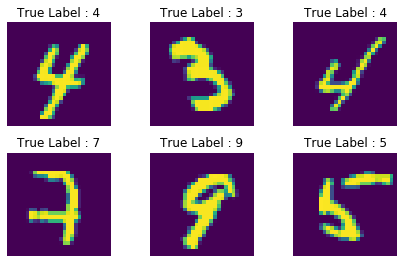

In [6]:
# plot some examples with there pixel and values and labels
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(img[i][0])
    plt.title('True Label : {}'.format(label[i]))
    plt.axis('off')

In [7]:
# Build the Convolution Neural Network
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST,self).__init__()
        
        # convolution layer 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=5,
                              stride=1,padding=2)
        
        # ReLU activation 
        self.relu1 = nn.ReLU()
        
        # maxpool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        # convolution 2
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,
                              stride=1,padding=2)
        
        # ReLU activation 
        self.relu2 = nn.ReLU()
        
        # maxpool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        # fully connected 1
        self.fc1 = nn.Linear(7*7*64,1000)
        # fully connected 2
        self.fc2 = nn.Linear(1000,10)
        
    def forward(self,x):
        
        # convolution 1
        out = self.cnn1(x)
    
        # activation function
        out = self.relu1(out)
        # maxpool 1
        out = self.maxpool1(out)

        
        # convolution 2
        out = self.cnn2(out)

        # activation function
        out = self.relu2(out)
        # maxpool 2
        out = self.maxpool2(out)
  
        
        # flatten the output
        out = out.view(out.size(0),-1)

        
        # fully connected layers
        out = self.fc1(out)
        out = self.fc2(out)


        return out

In [8]:
# define model and other parameters
cnn_model = CNN_MNIST()

# cross entropy loss
error = nn.CrossEntropyLoss()

# define the optimizer
optimizer = optim.SGD(cnn_model.parameters(),lr=learning_rate,momentum=momentum)

In [9]:
# model trainning
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(int(n_epochs)):
    for i, (image,labels) in enumerate(train_loader):
        
        train = Variable(image)
        labels = Variable(labels)

        
        # clear gradient
        optimizer.zero_grad()
        
        # forward propagation
        output = cnn_model(train)
        
        # calculate softmax and cross entropy loss
        loss = error(output,labels)
        
        # calculate gradients
        loss.backward()
        
        # update the optimizer
        optimizer.step()
        
        count += 1
        
        if count % 50 ==0:
            # calculate the accuracy
            correct = 0
            total = 0
            
            # iterate through the test data
            for image, labels in test_loader:
                
                test = Variable(image)
                
                # forward propagation
                output = cnn_model(test)
                
                # get prediction
                predict = torch.max(output.data,1)[1]
                
                # total number of labels
                total += len(labels)
                
                # correct prediction
                correct += (predict==labels).sum()
                
            # accuracy
            accuracy = 100*correct/float(total)
            
            # store loss, number of iteration, and accuracy
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            # save the model and the optimizer in case to use it further
            torch.save(cnn_model.state_dict(),r'C:\Users\Syahrir Ridha\pytorch\model.pth')
            torch.save(optimizer.state_dict(),r'C:\Users\Syahrir Ridha\pytorch\optimizer.pth')
            
            # print loss and accurcay as the algorithm progresses
            if count % 500 ==0:
                print('Iteration :{}    Loss :{}    Accuracy :{}'.format(count,loss.item(),accuracy))

Iteration :500    Loss :0.06665525585412979    Accuracy :96


In [10]:
# With less than 1000 iterations we were able to get accurcay of 96%
# now we check the data prediction capacity by plotting the predicted and given label
# over few testing examples

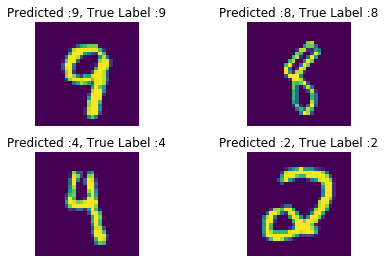

In [44]:
def plot(data):
    _,(img,label) = next(enumerate(data))
    with torch.no_grad():
        output = cnn_model(img)
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.tight_layout()
        pred = output.data.max(1,keepdim=True)[1][i].item()
        plt.imshow(img[i][0],interpolation='none')
        plt.axis('off')
        plt.title('Predicted :{}, True Label :{}'.format(pred,label[i]))
        
plot(test_loader)

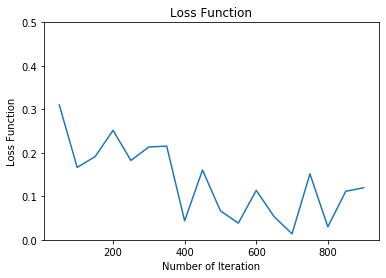

In [49]:
# plot the loss and accuracy
# loss function
plt.plot(iteration_list,loss_list)
plt.xlabel('Number of Iteration')
plt.ylabel('Loss Function')
plt.title('Loss Function')
plt.ylim(0,0.5);

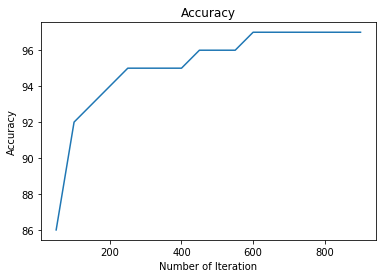

In [47]:
# accuracy function
plt.plot(iteration_list,accuracy_list)
plt.xlabel('Number of Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy');